# Marker selection of KEGG gene families from 793 EMP metagenome-assembled genomes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pmean
import os, lzma, re

In [2]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 12,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

Functions

In [3]:
def adjMatv2(edges_ogs, edges_genomes):
    # Get unique elements
    ogs, ogs_indices = np.unique(edges_ogs, return_inverse = True)
    genomes, genomes_indices = np.unique(edges_genomes, return_inverse = True)
    # Calculate bin counts for each combination of indices
    counts = np.bincount(ogs_indices * len(genomes) + genomes_indices, minlength = len(ogs) * len(genomes))
    # Reshape counts as adjacency matrix
    adj = counts.reshape(len(ogs), len(genomes))
    return adj, genomes, ogs

In [4]:
def save_genes(genes, fOut):
    with open(fOut, 'w') as f:
        for gene in genes:
            f.write(f'{gene}\n')

In [5]:
def save_markers_per_genome(markers_per_genome, fOut):
    with open(fOut, 'w') as f:
        for genome, number in markers_per_genome.items():
            f.write(f'{genome}:{number}\n')

In [6]:
def remove_genes(adj_mod):
    remove = np.array([i for i in range(len(adj_mod)) if adj_mod[i].sum() < 4])
    return remove

In [7]:
def greedy_power_mean_sample_final(data, k, p, pseudocount, min_universality_genes):
    
    # Size
    n, m = data.shape

    # Matrix is empty
    if n == 0 or m == 0:
        raise ValueError(f'Matrix is empty!')

    # Matrix contains only zeroes
    if (data == 0).all():
        raise ValueError(f'Matrix only contains 0\'s')

    if (data.sum(axis = 1) == min_universality_genes).all():
        raise ValueError(f'Matrix only contains genes present in less than {min_universality_genes}')

    if k >= n:
        raise ValueError(f'k should be smaller than {n}')
    
    # Add pseudocount
    data = data + pseudocount

    # cumulative gene counts
    counts = np.zeros(m, dtype = int)

    # gene indices in original data matrix
    indices = np.arange(n)

    # indices of selected genes
    selected = []

    # will select k genes sequentially
    for i in range(k):
        # calculate counts after adding each gene
        sums_ = counts + data

        # select a gene that maximizes the power mean gene count per genome, using the cumulative matric
        if isinstance(p, int) or isinstance(p, np.int64): 
            choice = pmean(sums_, int(p), axis = 1).argmax()
        elif p == 'min':
            choice = sums_.min(axis = 1).argmax()
        elif p == 'max':
            choice = sums_.max(axis = 1).argmax()
        else:
            raise ValueError(f'Invalid p: {p}.')

        # append index of selected gene
        selected.append(indices[choice])

        # update per-species gene counts
        counts = sums_[choice]

        # remove selected gene from data matrix
        data = np.delete(data, choice, axis = 0)

        # remove selected gene from indices
        indices = np.delete(indices, choice)

    return np.sort(np.array(selected))

In [8]:
def load_mapping(file):
    contigs = defaultdict(list)
    with open(file, 'r') as f:
        for line in f:
            l = line.strip().split(',')
            contig_id = l[0]
            prokka_id = l[1]
            contigs[contig_id].append(prokka_id)
    return dict(contigs)

In [9]:
def parse_kofamscan(file):
    '''
    Parse KOfamscan output file
    '''
    results = []
    with open(file, 'r') as f:
        for line in f:
            if not line.startswith('#'):
                tmp = re.sub('\s+', ' ', line.strip()).split(' ')
                # Omit the description column, ko_score, and e-value
                orf, ko, bit_score = tmp[0], tmp[1], float(tmp[3])
                results.append([orf, ko, bit_score])
    return results

Load name of MAGs

In [10]:
bins = np.loadtxt('./input_data/emp/mags.txt', dtype = 'str')
bins.shape

(811,)

Load annotation statistics

In [11]:
df_bins = pd.read_csv(f'./input_data/emp/mags_statistics_kegg.tsv', index_col = 0, sep = '\t')
df_bins.shape

(811, 3)

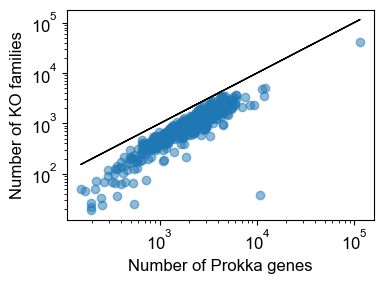

In [12]:
plt.figure(figsize = (4, 3))
plt.scatter(df_bins['num_prokka_genes'], df_bins['num_ko_families'], alpha = 0.5)
plt.plot(df_bins['num_prokka_genes'], df_bins['num_prokka_genes'], color = 'k', lw = 1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Prokka genes')
plt.ylabel('Number of KO families')
plt.show()

Remove bins outside the diagonal

In [13]:
to_exclude = []

In [14]:
to_exclude.extend(df_bins.query('num_prokka_genes >= 1e4 and num_ko_families <= 300').index.to_list())
to_exclude.extend(df_bins.query('num_ko_families <= 20').index.to_list())
to_exclude.extend(df_bins.query('num_prokka_genes > 1e5').index.to_list())

Remove environments with less than 5 bins

In [15]:
to_exclude.extend(df_bins[df_bins.index.str.startswith('Steppe')].index.to_list())
to_exclude.extend(df_bins[df_bins.index.str.startswith('Mayer_watershed')].index.to_list())
to_exclude.extend(df_bins[df_bins.index.str.startswith('Jensen_Benthic')].index.to_list())
to_exclude.extend(df_bins[df_bins.index.str.startswith('Lichen')].index.to_list())
to_exclude.extend(df_bins[df_bins.index.str.startswith('Seedorf_soil')].index.to_list())
to_exclude.extend(df_bins[df_bins.index.str.startswith('Marsh')].index.to_list())

In [16]:
df_bins = df_bins[~df_bins.index.isin(to_exclude)]
df_bins.shape

(793, 3)

In [17]:
bins = df_bins.index.values
bins.shape

(793,)

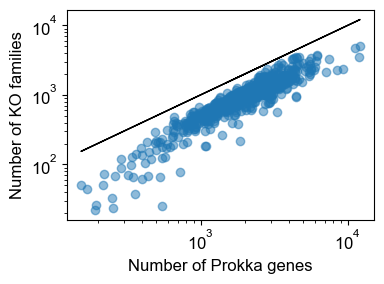

In [18]:
plt.figure(figsize = (4, 3))
plt.scatter(df_bins['num_prokka_genes'], df_bins['num_ko_families'], alpha = 0.5)
plt.plot(df_bins['num_prokka_genes'], df_bins['num_prokka_genes'], color = 'k', lw = 1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Prokka genes')
plt.ylabel('Number of KO families')
plt.show()

Load KOfamscan of bins

In [19]:
%%time
results = []
for bin in bins:
    # Load file
    with open(f'./input_data/emp/kegg/{bin}.tsv', 'r') as f:
        for line in f:
            row = line.strip().split('\t')
            orf, ko, bit_score = row[0], row[1], float(row[3])
            results.append([orf, ko, bit_score, bin])

CPU times: user 1.33 s, sys: 157 ms, total: 1.49 s
Wall time: 1.63 s


In [20]:
len(results)

839302

In [21]:
df = pd.DataFrame(results, columns = ['orf', 'ko', 'bit_score', 'bin'])
df.set_index('orf', inplace = True)
df['genome'] = df.index.map(lambda x: x.split('_')[0])

In [22]:
df.shape

(839302, 4)

Control copy number: For each genome and gene, discard those genes with a score less than `x` of the top `score`

In [23]:
threshold = 0.0
# Calculate the maximum score for each genome and pfam combination
max_scores = df.groupby(['genome', 'ko'])['bit_score'].transform('max')
# Keep rows where the score is greater than or equal to max_score * threshold
filtered_df = df[df['bit_score'] >= max_scores * threshold]

In [24]:
filtered_df.shape

(839302, 4)

Convert to edges

In [25]:
edges_genomes = filtered_df['genome'].values
edges_ogs = filtered_df['ko'].values

Build copy number matrix

In [26]:
%%time
adj, genomes, ogs = adjMatv2(edges_ogs, edges_genomes)
adj.shape

CPU times: user 1.73 s, sys: 27.3 ms, total: 1.76 s
Wall time: 1.84 s


(8003, 793)

Reformat data matrix

In [27]:
adj1 = adj

In [28]:
# Contains copy numbers
adj2 = adj1.copy()

In [29]:
adj1[adj1 > 1] = 1

Remove genes present in less than 4 genomes/species because `FastTree` requires at least three species and ASTRAL-pro uses quartets (i.e. four species)

In [30]:
# Copy presence/absence matrix
adj_mod = adj1.copy()
# Select genes to remove
remove = remove_genes(adj_mod)
# Remove genes
adj_mod = np.delete(adj_mod, remove, axis = 0)
# Remove genes from list
ogs_mod = np.delete(ogs, remove, axis = 0)

In [31]:
# Copy matrix
adj_mod2 = adj2.copy()
# Remove genes
adj_mod2 = np.delete(adj_mod2, remove, axis = 0)

In [32]:
adj_mod.shape

(6647, 793)

In [33]:
adj_mod2.shape

(6647, 793)

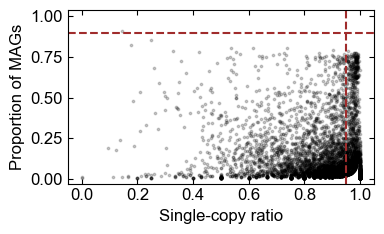

In [34]:
x = np.sum(adj_mod2 == 1, axis = 1) / np.sum(adj_mod2 >= 1, axis = 1)
y = np.sum(adj_mod2 >= 1, axis = 1) / adj_mod2.shape[1]

plt.figure(figsize = (4, 2.5))
plt.scatter(x, y, alpha = 0.2, color = 'k', s = 3, edgecolor = None)
# Threshold for presence and single-copy ratio
plt.axvline(x = 0.95, ls = 'dashed', color = '#a02c2cff')
plt.axhline(y = 0.90, ls = 'dashed', color = '#a02c2cff')
# plt.legend(title = 'Pfam type')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.xlabel('Single-copy ratio')
plt.ylabel('Proportion of MAGs')
plt.ylim(-0.03, 1.04)
plt.savefig(f'./figures/figure_1A_gene_family_space_emp_kegg.svg')
plt.show()

Number of gene families and proportion of gene families withing area defined by traditional criteria

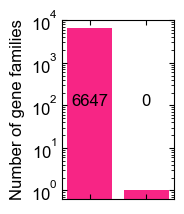

In [35]:
plt.figure(figsize = (2, 2.15))
# plt.bar([0, 1], [adj_mod.shape[0], y[(y > 0.9) & (x > 0.95)].shape[0]], color = '#4361ee')
plt.bar([0, 1], [adj_mod.shape[0], 1], color = '#f72585') # Pseudocount added for aesthetic purposes
plt.xticks([0, 1], ['', ''])
plt.text(0, 100, f'{adj_mod.shape[0] - y[(y > 0.9) & (x > 0.95)].shape[0]}', ha = 'center')
plt.text(1, 100, f'{y[(y > 0.9) & (x > 0.95)].shape[0]}', ha = 'center')
plt.yscale('log')
plt.ylabel('Number of gene families')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.savefig(f'./figures/figure_1A_number_gene_families_emp_kegg.svg')
plt.show()

Distribution of gene families across MAGs

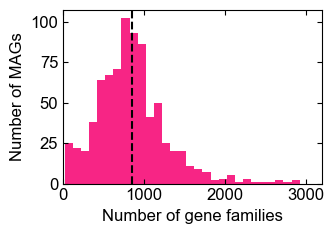

In [36]:
plt.figure(figsize = (3.5, 2.5))
plt.hist(adj_mod.sum(axis = 0), bins = 'auto', color = '#f72585')
plt.axvline(x = np.mean(adj_mod.sum(axis = 0)), ls = 'dashed', color = 'k')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.xlabel('Number of gene families')
plt.ylabel('Number of MAGs')
plt.xlim(0, 3200)
plt.savefig(f'./figures/figure_1A_number_gene_families_histogram_emp_kegg.svg')
plt.show()

Select markers from KEGG gene families

In [37]:
# Change k to generate all sets (k = 10, 50, 100, 200, 400, 600, 800, 1000)
k = 10
ps = [0]

In [38]:
%%time
selected_genes_mod = {}
selected_genes_all_criteria_mod = []
# Iterate over criteria
for p in ps:
    print(f'\tp: {p}')
    select = greedy_power_mean_sample_final(adj_mod2, k, p = p, pseudocount = 0.1, min_universality_genes = 1)
    selected_genes_all_criteria_mod.append(set(select))
    selected_genes_mod[p] = select

	p: 0
CPU times: user 882 ms, sys: 220 ms, total: 1.1 s
Wall time: 581 ms


Save markers

In [39]:
all_genes = set.union(*selected_genes_all_criteria_mod)

In [40]:
dataPathOut = f'./output_data/emp/marker_genes/kegg/bit_score_threshold_{threshold}'
fOut = f'{dataPathOut}/all_genes.txt'
save_genes([ogs_mod[i] for i in all_genes], fOut)

Remove genomes with less than $k * 0.25$ marker genes

In [41]:
genomes_to_keep = genomes[adj_mod[selected_genes_mod[p]].sum(axis = 0) >= k * 0.25]
genomes_to_keep.shape

(759,)

Save ORFs

In [42]:
%%time
for i in all_genes:
    gene = ogs_mod[i]
    with open(f'{dataPathOut}/orfs/{gene}.txt', 'w') as f:
        orfs = filtered_df.query('ko == @gene')
        orfs = orfs[orfs['genome'].isin(genomes_to_keep)].index.values
        for orf in orfs:
            f.write(f'{orf}\n')

CPU times: user 492 ms, sys: 16.1 ms, total: 509 ms
Wall time: 515 ms


Save number of markers per MAG

In [43]:
num_marker_genes_per_genome = {genome : number for genome, number in zip(genomes, adj_mod[selected_genes_mod[p]].sum(axis = 0))}

In [44]:
save_markers_per_genome(num_marker_genes_per_genome, f'{dataPathOut}/num_markers_per_genome_k_{k}_p_{p}.txt')

# Marker selection of EggNog gene families from 793 EMP metagenome-assembled genomes

In [45]:
bins = np.loadtxt('./input_data/emp/mags.txt', dtype = 'str')
bins.shape

(811,)

Load annotation statistics

In [46]:
df_bins = pd.read_csv(f'./input_data/emp/mags_statistics_eggnog.tsv', index_col = 0, sep = '\t')
df_bins.shape

(811, 3)

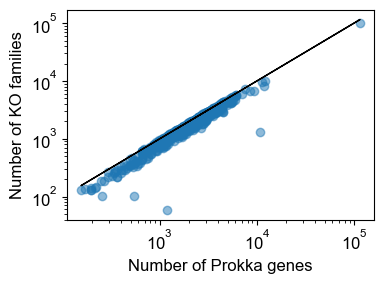

In [47]:
plt.figure(figsize = (4, 3))
plt.scatter(df_bins['num_prokka_genes'], df_bins['num_og_families'], alpha = 0.5)
plt.plot(df_bins['num_prokka_genes'], df_bins['num_prokka_genes'], color = 'k', lw = 1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Prokka genes')
plt.ylabel('Number of KO families')
plt.show()

Remove bins outside the diagonal

In [48]:
to_exclude = []

In [49]:
to_exclude.extend(df_bins.query('num_prokka_genes >= 1e4 and num_og_families <= 2e3').index.to_list())
to_exclude.extend(df_bins.query('num_og_families <= 100').index.to_list())
to_exclude.append('SaltMarsh.Metabat.Bin.9')
to_exclude.extend(df_bins.query('num_prokka_genes > 1e5').index.to_list())

Remove environments with less than 5 bins

In [50]:
to_exclude.extend(df_bins[df_bins.index.str.startswith('Steppe')].index.to_list())
to_exclude.extend(df_bins[df_bins.index.str.startswith('Mayer_watershed')].index.to_list())
to_exclude.extend(df_bins[df_bins.index.str.startswith('Jensen_Benthic')].index.to_list())
to_exclude.extend(df_bins[df_bins.index.str.startswith('Lichen')].index.to_list())
to_exclude.extend(df_bins[df_bins.index.str.startswith('Seedorf_soil')].index.to_list())
to_exclude.extend(df_bins[df_bins.index.str.startswith('Marsh')].index.to_list())

In [51]:
df_bins = df_bins[~df_bins.index.isin(to_exclude)]
df_bins.shape

(793, 3)

In [52]:
bins = df_bins.index.values
bins.shape

(793,)

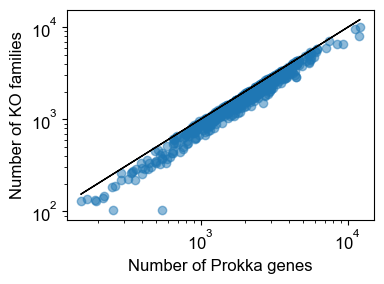

In [53]:
plt.figure(figsize = (4, 3))
plt.scatter(df_bins['num_prokka_genes'], df_bins['num_og_families'], alpha = 0.5)
plt.plot(df_bins['num_prokka_genes'], df_bins['num_prokka_genes'], color = 'k', lw = 1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Prokka genes')
plt.ylabel('Number of KO families')
plt.show()

Load Eggnog-mapper of bins

In [54]:
%%time
results = []
for bin in bins:
    # Load file
    with open(f'./input_data/emp/eggnog/{bin}.emapper.annotations', 'r') as f:
        for line in f:
            if not line.startswith('#'):
                row = line.strip().split('\t')
                orf, bit_score, og = row[0], float(row[3]), row[4].split('|')[0]
                results.append([orf, og.split('@')[0], bit_score, bin])

CPU times: user 5.39 s, sys: 308 ms, total: 5.69 s
Wall time: 6.46 s


In [55]:
len(results)

1496419

In [56]:
df = pd.DataFrame(results, columns = ['orf', 'og', 'bit_score', 'bin'])
df.set_index('orf', inplace = True)
df['genome'] = df.index.map(lambda x: x.split('_')[0])

In [57]:
df.shape

(1496419, 4)

Control copy number: For each genome and gene, discard those genes with a score less than `x` of the top `score`

In [58]:
threshold = 0.0
# Calculate the maximum score for each genome and pfam combination
max_scores = df.groupby(['genome', 'og'])['bit_score'].transform('max')
# Keep rows where the score is greater than or equal to max_score * threshold
filtered_df = df[df['bit_score'] >= max_scores * threshold]

In [59]:
filtered_df.shape

(1496419, 4)

Convert to edges

In [60]:
edges_genomes = filtered_df['genome'].values
edges_ogs = filtered_df['og'].values

Build copy number matrix

In [61]:
%%time
adj, genomes, ogs = adjMatv2(edges_ogs, edges_genomes)
adj.shape

CPU times: user 3.44 s, sys: 103 ms, total: 3.55 s
Wall time: 3.54 s


(52527, 793)

Reformat matrix

In [62]:
adj1 = adj

In [63]:
# Contains copy numbers
adj2 = adj1.copy()

In [64]:
adj1[adj1 > 1] = 1

Remove genes present in less than 4 genomes/species because `FastTree` requires at least three species and ASTRAL-pro uses quartets (i.e. four species)

In [65]:
# Copy presence/absence matrix
adj_mod = adj1.copy()
# Select genes to remove
remove = remove_genes(adj_mod)
# Remove genes
adj_mod = np.delete(adj_mod, remove, axis = 0)
# Remove genes from list
ogs_mod = np.delete(ogs, remove, axis = 0)

In [66]:
# Copy matrix
adj_mod2 = adj2.copy()
# Remove genes
adj_mod2 = np.delete(adj_mod2, remove, axis = 0)

In [67]:
adj_mod.shape

(13575, 793)

In [68]:
adj_mod2.shape

(13575, 793)

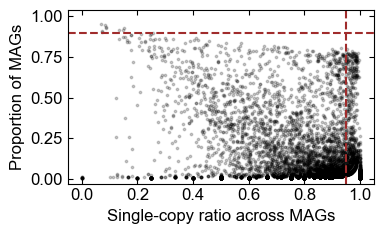

In [69]:
x = np.sum(adj_mod2 == 1, axis = 1) / np.sum(adj_mod2 >= 1, axis = 1)
y = np.sum(adj_mod2 >= 1, axis = 1) / adj_mod2.shape[1]

plt.figure(figsize = (4, 2.5))
plt.scatter(x, y, alpha = 0.2, color = 'k', s = 3, edgecolor = None)
# Threshold for presence and single-copy ratio
plt.axvline(x = 0.95, ls = 'dashed', color = '#a02c2cff')
plt.axhline(y = 0.90, ls = 'dashed', color = '#a02c2cff')
# plt.legend(title = 'Pfam type')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.xlabel('Single-copy ratio across MAGs')
plt.ylabel('Proportion of MAGs')
plt.ylim(-0.03, 1.04)
plt.savefig(f'./figures/figure_S1A_gene_family_space_emp_eggnog.svg')
plt.show()

Number of gene families and proportion of gene families withing area defined by traditional criteria

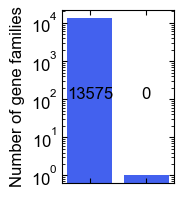

In [70]:
plt.figure(figsize = (2, 2.15))
# plt.bar([0, 1], [adj_mod.shape[0], y[(y > 0.9) & (x > 0.95)].shape[0]], color = '#4361ee')
plt.bar([0, 1], [adj_mod.shape[0], 1], color = '#4361ee') # Pseudocount added for aesthetic purposes
plt.xticks([0, 1], ['', ''])
plt.text(0, 100, f'{adj_mod.shape[0] - y[(y > 0.9) & (x > 0.95)].shape[0]}', ha = 'center')
plt.text(1, 100, f'{y[(y > 0.9) & (x > 0.95)].shape[0]}', ha = 'center')
plt.yscale('log')
plt.ylabel('Number of gene families')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.savefig(f'./figures/figure_S1A_number_gene_families_emp_eggnog.svg')
plt.show()

Distribution of gene families across MAGs

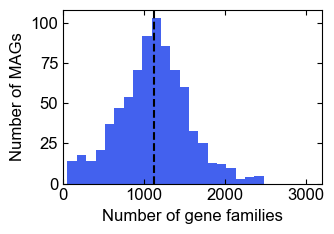

In [71]:
plt.figure(figsize = (3.5, 2.5))
plt.hist(adj_mod.sum(axis = 0), bins = 'auto', color = '#4361ee')
plt.axvline(x = np.mean(adj_mod.sum(axis = 0)), ls = 'dashed', color = 'k')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.xlabel('Number of gene families')
plt.ylabel('Number of MAGs')
plt.xlim(0, 3200)
plt.savefig(f'./figures/figure_S1A_number_gene_families_histogram_emp_eggnog.svg')
plt.show()

Select markers from EggNog gene families

In [72]:
# Change k to generate all sets (k = 10, 50, 100, 200, 400, 600, 800, 1000)
k = 10
ps = [0]

In [73]:
%%time
selected_genes_mod = {}
selected_genes_all_criteria_mod = []
# Iterate over criteria
for p in ps:
    print(f'\tp: {p}')
    select = greedy_power_mean_sample_final(adj_mod2, k, p = p, pseudocount = 0.1, min_universality_genes = 1)
    selected_genes_all_criteria_mod.append(set(select))
    selected_genes_mod[p] = select

	p: 0
CPU times: user 1.5 s, sys: 326 ms, total: 1.83 s
Wall time: 1.29 s


Save markers

In [74]:
all_genes = set.union(*selected_genes_all_criteria_mod)

In [75]:
dataPathOut = f'./output_data/emp/marker_genes/eggnog/bit_score_threshold_{threshold}'
fOut = f'{dataPathOut}/all_genes.txt'
save_genes([ogs_mod[i] for i in all_genes], fOut)

Remove genomes with less than $k * 0.25$ marker genes

In [76]:
genomes_to_keep = genomes[adj_mod[selected_genes_mod[p]].sum(axis = 0) >= k * 0.25]
genomes_to_keep.shape

(785,)

Save ORFs

In [80]:
%%time
for i in all_genes:
    gene = ogs_mod[i]
    with open(f'{dataPathOut}/orfs/{gene}.txt', 'w') as f:
        orfs = filtered_df.query('og == @gene')
        orfs = orfs[orfs['genome'].isin(genomes_to_keep)].index.values
        for orf in orfs:
            f.write(f'{orf}\n')

CPU times: user 994 ms, sys: 18.8 ms, total: 1.01 s
Wall time: 1.02 s


Save number of markers per MAG

In [81]:
num_marker_genes_per_genome = {genome : number for genome, number in zip(genomes, adj_mod[selected_genes_mod[p]].sum(axis = 0))}

In [82]:
save_markers_per_genome(num_marker_genes_per_genome, f'{dataPathOut}/num_markers_per_genome_k_{k}_p_{p}.txt')